 # Trabajo Mineria TEL354
 #### Lucas Petit
 #### Martín Ortega

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# Cargar los archivos CSV
sueldo_df = pd.read_csv("sueldo_minimo_chile.csv")           # 2009 a 2025
desempleo_df = pd.read_csv("Tasa desempleo.csv")               # 2010 a 2024 trimestres
empleo_df = pd.read_csv("tasa_empleo_formal_etario.csv")        # 2010 a 2024 trimestres
empleo_informal_df = pd.read_csv("tasa_empleo_informal_etario.csv")  # 2017 a 2024 trimestres
sueldo_nominal = pd.read_csv("sueldo_nominal_etario.csv")       # Anual 2010 a 2022
pib_percapita = pd.read_csv("Pib_percapita.csv")                # Anual 1960 a 2023 (el más útil)
dolar = pd.read_csv("dolar.csv", sep=";")                       # Mensual 2007 a 2025
ipc = pd.read_csv("ipc.csv", encoding="latin", sep=";")         # Mensual 2010 a 2025 (2023=100)

# Renombrar la columna "Índice" a "ipc" en el DataFrame de IPC
ipc = ipc.rename(columns={"Índice": "ipc"})

# Definir listas y claves de merge (no se usan directamente, pero aquí se mantienen para referencia)
lista = ["Trimestre Móvil", "Tramo etario", "Value"]
merge_keys = ["Trimestre Móvil", "Tramo etario"]

# Fusionar los DataFrames de empleo formal y desempleo por "Trimestre Móvil" y "Tramo etario"
df_empleabilidad = pd.merge(
    empleo_df[["Trimestre Móvil", "Tramo etario", "Value"]],
    desempleo_df[["Trimestre Móvil", "Tramo etario", "Value"]],
    on=["Trimestre Móvil", "Tramo etario"],
    how="inner"
)

# Renombrar columnas para mayor claridad
df_empleabilidad = df_empleabilidad.rename(columns={
    "Value_x": "Tasa de empleo",
    "Value_y": "Tasa de desempleo"
})

# Extraer el año a partir de la columna "Trimestre Móvil"
df_empleabilidad["Año"] = df_empleabilidad["Trimestre Móvil"].str.extract(r"(\d{4})").astype(int)

# Diccionario para mapear abreviaturas de meses a números
meses = {
    "ene": 1, "feb": 2, "mar": 3, "abr": 4, "may": 5, "jun": 6,
    "jul": 7, "ago": 8, "sep": 9, "oct": 10, "nov": 11, "dic": 12
}

# Extraer el mes desde la columna "Trimestre Móvil" (se toma la parte de caracteres que representa el mes)
df_empleabilidad["Mes"] = df_empleabilidad["Trimestre Móvil"].str.slice(start=9, stop=12).replace(meses)

# Ajustar el año para los registros de enero, suponiendo que en ese caso corresponde al año siguiente
df_empleabilidad.loc[df_empleabilidad['Mes'] == 1, 'Año'] = df_empleabilidad[df_empleabilidad["Mes"] == 1]["Año"] + 1

# Procesar el DataFrame de sueldo mínimo:
# Convertir la columna "fecha" a datetime, reindexar con un rango completo y rellenar valores faltantes
sueldo_df["fecha"] = pd.to_datetime(sueldo_df["fecha"], errors='coerce')
date_range = pd.date_range(start="2009-07-01", end="2025-05-01", freq='MS')
sueldo_df = sueldo_df.set_index("fecha").reindex(date_range).reset_index().ffill().rename(columns={"index": "fecha"})

# Extraer el año y el mes para realizar los merges
sueldo_df['Año'] = sueldo_df['fecha'].dt.year
sueldo_df['Mes'] = sueldo_df['fecha'].dt.month
sueldo_df = sueldo_df.rename(columns={"monto_clp": "Sueldo minimo"})

# Fusionar df_empleabilidad con sueldo_df por "Año" y "Mes"
df_empleabilidad = pd.merge(
    df_empleabilidad[["Año", "Mes", "Tramo etario", "Tasa de empleo", "Tasa de desempleo"]],
    sueldo_df[["Año", "Mes", "Sueldo minimo"]],
    on=["Año", "Mes"],
    how="inner"
)

# Fusionar con el DataFrame de IPC (ya renombrado a "ipc")
df_empleabilidad = pd.merge(
    df_empleabilidad,
    ipc[["Año", "Mes", "ipc"]],
    on=["Año", "Mes"],
    how="inner"
)

# Procesar el DataFrame del dólar
# Extraer el mes (de las primeras tres letras) y el año desde la columna "Periodo"
dolar["Mes"] = dolar["Periodo"].str.slice(start=0, stop=3).replace(meses)
dolar["Año"] = dolar["Periodo"].str.extract(r"(\d{4})").astype(int)

# Fusionar con el DataFrame de dólar
df_empleabilidad = pd.merge(
    df_empleabilidad,
    dolar[["Año", "Mes", "Dólar observado"]],
    on=["Año", "Mes"],
    how="inner"
)  # Hasta 2024

# Procesar el DataFrame de PIB per cápita:
# Filtrar para Chile, eliminar columnas innecesarias, transponer y renombrar las columnas
pib_percapita = pib_percapita[pib_percapita["Country Name"] == "Chile"] \
    .drop(["Country Name", "Country Code", "Indicator Name", "Indicator Code"], axis=1) \
    .transpose().reset_index().rename(columns={"index": "Año", 39: "PIB per capita"}).dropna()
pib_percapita["Año"] = pib_percapita["Año"].astype(int)

# Fusionar con el DataFrame de empleabilidad usando el PIB per cápita (hasta 2023)
df_empleabilidad_pib = pd.merge(
    df_empleabilidad,
    pib_percapita,
    on=["Año"],
    how="inner"
)

# Fusionar con el DataFrame de sueldo nominal (hasta 2022)
df_empleabilidad_sueldo = pd.merge(
    df_empleabilidad_pib,
    sueldo_nominal[["Año", "Tramo etario", "Value"]].rename(columns={"Value": "Sueldo nominal"}),
    on=["Año", "Tramo etario"],
    how="inner"
)

# Asegurarse que los valores de "ipc" sean numéricos; se reemplazan comas por puntos para convertirlos
df_empleabilidad_sueldo["ipc"] = pd.to_numeric(
    df_empleabilidad_sueldo["ipc"].astype(str).str.replace(",", "."),
    errors='coerce'
)

# Convertir "Dólar observado" a numérico, gestionando posibles comas
df_empleabilidad_sueldo["Dólar observado"] = pd.to_numeric(
    df_empleabilidad_sueldo["Dólar observado"].astype(str).str.replace(",", "."),
    errors='coerce'
)

# Crear columna: Sueldo mínimo en USD dividiendo por el dólar observado y redondeando a 2 decimales
df_empleabilidad_sueldo["Sueldo mínimo USD"] = (
    df_empleabilidad_sueldo["Sueldo minimo"] / df_empleabilidad_sueldo["Dólar observado"]
).round(2)

# Crear columna: Sueldo nominal en USD redondeado igual que el anterior
df_empleabilidad_sueldo["Sueldo nominal USD"] = (
    df_empleabilidad_sueldo["Sueldo nominal"] / df_empleabilidad_sueldo["Dólar observado"]
).round(2)

# Crear columna: Razón entre sueldo nominal y sueldo mínimo (ambos en USD) redondeado a 2 decimales
df_empleabilidad_sueldo["Razón sueldo nominal/minimo"] = (
    df_empleabilidad_sueldo["Sueldo nominal USD"] / df_empleabilidad_sueldo["Sueldo mínimo USD"]
).round(2)

# Eliminar las columnas originales de sueldos en CLP para evitar confusiones
df_empleabilidad_sueldo = df_empleabilidad_sueldo.drop(columns=["Sueldo minimo", "Sueldo nominal"])

# Crear columna Booleana para marcar el período pandémico
df_empleabilidad_sueldo["Pandemia"] = (
    ((df_empleabilidad_sueldo["Año"] > 2020) & (df_empleabilidad_sueldo["Año"] < 2022))
    | ((df_empleabilidad_sueldo["Año"] == 2020) & (df_empleabilidad_sueldo["Mes"] >= 3))
    | ((df_empleabilidad_sueldo["Año"] == 2022) & (df_empleabilidad_sueldo["Mes"] <= 12))
)

# Realizar la codificación de la variable categórica "Tramo etario" usando get_dummies
df_encoded = pd.get_dummies(df_empleabilidad_sueldo, columns=["Tramo etario"])

# Mostrar las primeras filas del DataFrame final
df_encoded

C:\Users\orteg\AppData\Local\Temp\ipykernel_4888\3587079781.py:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_empleabilidad["Mes"] = df_empleabilidad["Trimestre Móvil"].str.slice(start=9, stop=12).replace(meses)
C:\Users\orteg\AppData\Local\Temp\ipykernel_4888\3587079781.py:82: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dolar["Mes"] = dolar["Periodo"].str.slice(start=0, stop=3).replace(meses)


,Año,Mes,Tasa de empleo,Tasa de desempleo,ipc,Dólar observado,PIB per capita,Sueldo mínimo USD,Sueldo nominal USD,Razón sueldo nominal/minimo,Pandemia,Tramo etario_15-24 años,Tramo etario_25-34 años,Tramo etario_35-44 años,Tramo etario_45-54 años,Tramo etario_55-64 años,Tramo etario_65 años y más,Tramo etario_Total
0,2010,3,54.139000,9.227598,57.82,523.16,12632.870473,315.39,727.90,2.31,False,False,False,False,False,False,False,True
1,2010,3,30.973043,20.215636,57.82,523.16,12632.870473,315.39,381.99,1.21,False,True,False,False,False,False,False,False
2,2010,3,70.121048,10.727110,57.82,523.16,12632.870473,315.39,741.96,2.35,False,False,True,False,False,False,False,False
3,2010,3,73.710138,6.867825,57.82,523.16,12632.870473,315.39,822.37,2.61,False,False,False,True,False,False,False,False
4,2010,3,68.720825,6.300679,57.82,523.16,12632.870473,315.39,772.79,2.45,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,2022,12,72.758222,8.969885,97.21,875.66,15451.131958,456.80,845.80,1.85,True,False,True,False,False,False,False,False
1074,2022,12,77.752721,6.646202,97.21,875.66,15451.131958,456.80,1044.13,2.29,True,False,False,True,False,False,False,False
1075,2022,12,73.267255,6.337989,97.21,875.66,15451.131958,456.80,928.40,2.03,True,False,False,False,True,False,False,False
1076,2022,12,60.654668,6.127412,97.21,875.66,15451.131958,456.80,758.34,1.66,True,False,False,False,False,True,False,False


Esta implementación tiene como objetivo central integrar múltiples fuentes de datos socioeconómicos de Chile —como tasas de empleo, desempleo, sueldos, IPC, dólar observado y PIB per cápita— para construir un DataFrame unificado y limpio que permita analizar la evolución del mercado laboral en función de variables económicas clave. Para ello, se realizó una cuidadosa limpieza, estandarización y fusión de distintos conjuntos de datos, ajustando formatos de fecha, nombres de columnas y tipos de datos. También se generaron variables nuevas, como los sueldos en dólares y la razón entre sueldo nominal y mínimo, para facilitar comparaciones y análisis internacionales. La codificación de la variable categórica “Tramo etario” mediante get_dummies permite aplicar modelos estadísticos o de aprendizaje automático que requieran variables numéricas. Además, se identificó el período pandémico mediante una columna booleana, lo que permitirá controlar o analizar el impacto de la pandemia sobre las variables laborales. Esta integración rigurosa permite disponer de un conjunto de datos robusto para análisis econométrico o visualizaciones significativas.

In [9]:
df_encoded.dtypes

Año                              int32
Mes                              int64
Tasa de empleo                 float64
Tasa de desempleo              float64
ipc                            float64
Dólar observado                float64
PIB per capita                 float64
Sueldo mínimo USD              float64
Sueldo nominal USD             float64
Razón sueldo nominal/minimo    float64
Pandemia                          bool
Tramo etario_15-24 años           bool
Tramo etario_25-34 años           bool
Tramo etario_35-44 años           bool
Tramo etario_45-54 años           bool
Tramo etario_55-64 años           bool
Tramo etario_65 años y más        bool
Tramo etario_Total                bool
dtype: object

In [23]:
df_encoded.describe()

,Año,Mes,Tasa de empleo,Tasa de desempleo,ipc,Dólar observado,PIB per capita,Sueldo mínimo USD,Sueldo nominal USD,Razón sueldo nominal/minimo
count,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.00000
mean,2016.077922,6.564935,55.732169,7.485957,71.873506,639.642597,14600.362117,397.644610,816.216438,2.06038
std,3.704179,3.427855,20.957753,4.926208,9.501781,124.079095,1039.193516,35.394654,192.974589,0.48429
min,2010.000000,1.000000,14.695963,1.406802,57.820000,462.940000,12632.870473,307.450000,362.000000,0.95000
25%,2013.000000,4.000000,30.668359,4.010574,62.980000,517.170000,13649.852046,370.310000,723.315000,1.81000
50%,2016.000000,7.000000,63.250580,6.192554,72.090000,651.275000,14529.676721,398.855000,852.765000,2.16500
75%,2019.000000,10.000000,73.570757,8.801904,77.960000,718.440000,15451.131958,425.020000,951.012500,2.41000
max,2022.000000,12.000000,79.445798,29.852019,97.210000,955.890000,16216.570647,473.140000,1211.250000,3.04000


La tabla mostrada corresponde a un resumen estadístico de las variables numéricas del DataFrame df_encoded, que contiene 1078 observaciones. Se incluyen estadísticas como media, desviación estándar, mínimo, percentiles y máximo para variables como "Tasa de empleo", "Tasa de desempleo", "ipc", "Dólar observado", "PIB per capita", y distintos indicadores salariales. La "Tasa de desempleo" tiene un promedio de 7.49% y un máximo de casi 30%, lo que refleja una alta variabilidad. El "Dólar observado" muestra una media de 639.6 y una desviación importante, con valores que van desde 462.94 hasta 955.89, evidenciando alta volatilidad. El "PIB per capita" también presenta cierta variabilidad con un promedio cercano a los 14,600 USD. El "Sueldo mínimo USD" varía entre 307.45 y 473.14, mientras que el "Sueldo nominal USD" va de 362 a más de 1,200 USD. La "Razón sueldo nominal/mínimo" tiene un valor medio de 2.06, lo que implica que en promedio el sueldo nominal duplica el mínimo, pero con casos donde la relación es apenas cercana a 1 y otros que superan el triple. Estos indicadores proveen una base sólida para análisis exploratorios y modelos predictivos. Además, permiten estudiar la evolución del mercado laboral y su relación con condiciones económicas clave entre 2010 y 2022.

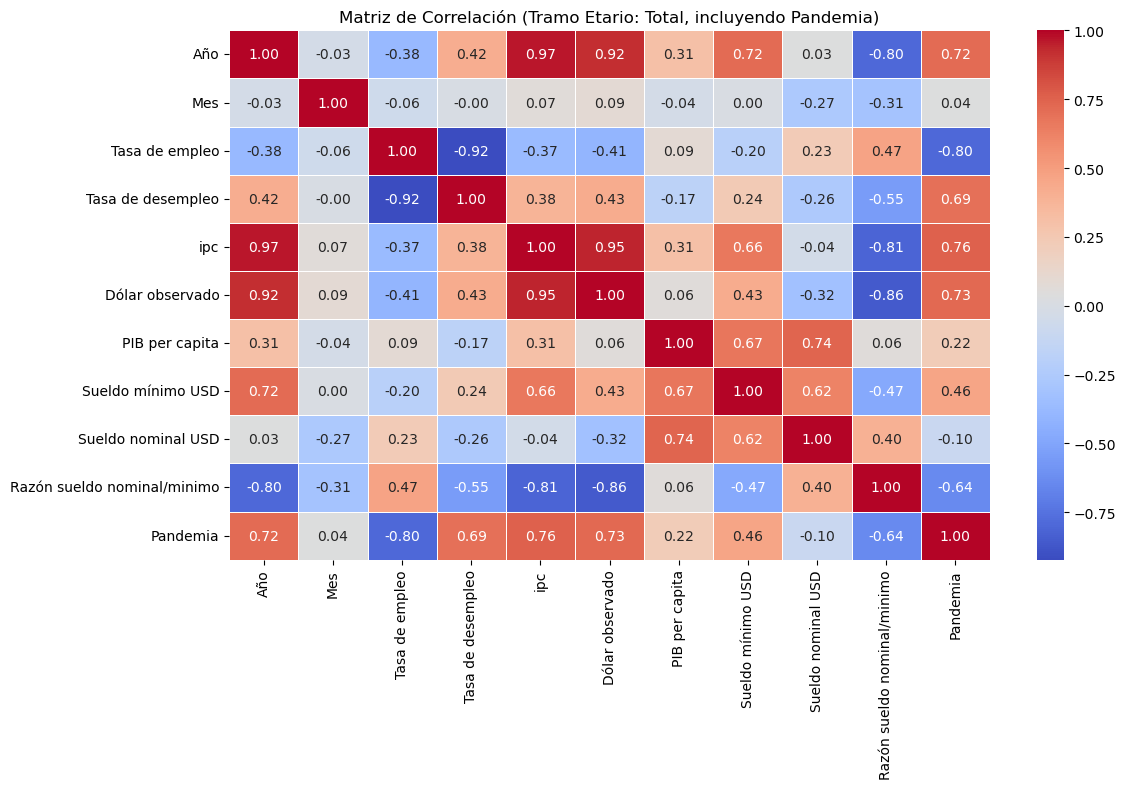


Suma de correlaciones absolutas (orden ascendente):
Mes                            1.894216
PIB per capita                 3.660461
Sueldo nominal USD             4.015307
Tasa de empleo                 4.912506
Tasa de desempleo              5.065189
Sueldo mínimo USD              5.466169
Pandemia                       6.155751
Dólar observado                6.172780
Año                            6.286998
ipc                            6.318237
Razón sueldo nominal/minimo    6.354403
dtype: float64


In [27]:
# Filtrar solo las filas donde el tramo etario sea "Total"
df_total = df_encoded[df_encoded["Tramo etario_Total"] == 1].copy()

# Asegurar que la columna Pandemia esté presente y sea numérica (True -> 1, False -> 0)
if "Pandemia" in df_total.columns:
    df_total["Pandemia"] = df_total["Pandemia"].astype(int)

# Seleccionar solo columnas numéricas
df_total_numeric = df_total.select_dtypes(include="number")

# Calcular la matriz de correlación
correlation_matrix = df_total_numeric.corr()

# Visualizar con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación (Tramo Etario: Total, incluyendo Pandemia)")
plt.tight_layout()
plt.show()

# Calcular y mostrar suma de correlaciones absolutas (orden ascendente)
suma_corr_abs = correlation_matrix.abs().sum().sort_values()
print("\nSuma de correlaciones absolutas (orden ascendente):")
print(suma_corr_abs)


Esta sección del código tiene como propósito analizar las relaciones entre las variables numéricas del conjunto de datos filtrado, específicamente para el tramo etario “Total”. Para lograrlo, primero se seleccionan únicamente las filas donde la columna Tramo etario_Total tenga valor 1, es decir, aquellas que representan el promedio general sin segmentación por edad. Esta decisión permite simplificar el análisis y enfocarse en el comportamiento agregado de las variables laborales y económicas a lo largo del tiempo, sin la variabilidad introducida por las diferencias etarias.

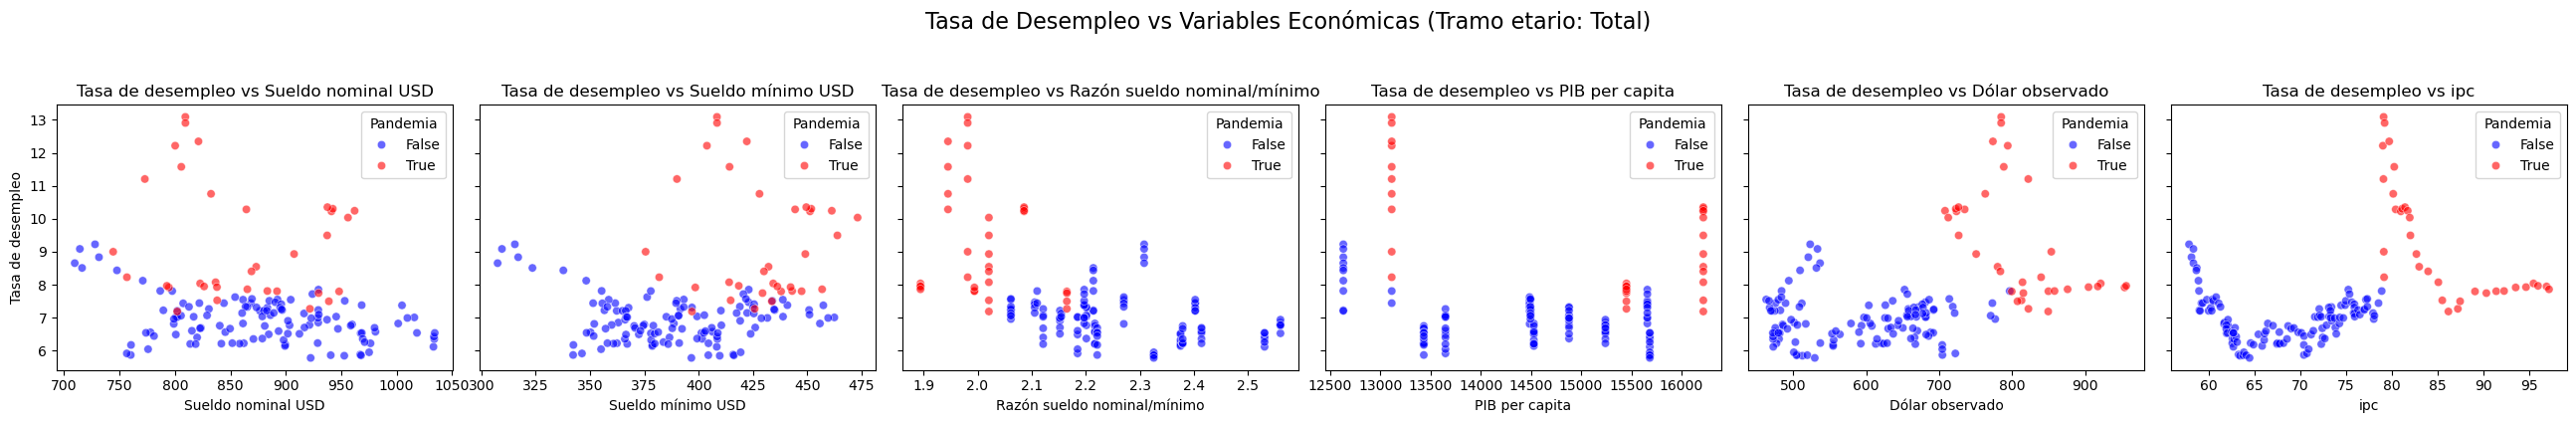

In [29]:
# Filtrar solo las filas donde el tramo etario sea "Total"
df_total = df_encoded[df_encoded["Tramo etario_Total"] == 1].copy()

# Asegurarse que la columna Pandemia esté en formato booleano
df_total["Pandemia"] = df_total["Pandemia"].astype(bool)

# Crear columna adicional: razón sueldo nominal / sueldo mínimo
df_total["Razón sueldo nominal/mínimo"] = df_total["Sueldo nominal USD"] / df_total["Sueldo mínimo USD"]

# Columnas de interés para este gráfico (agregamos la nueva variable)
x_vars = [
    "Sueldo nominal USD",
    "Sueldo mínimo USD",
    "Razón sueldo nominal/mínimo",
    "PIB per capita",
    "Dólar observado",
    "ipc"
]
y_var = "Tasa de desempleo"

# Eliminar filas con valores faltantes
df_plot = df_total[[y_var, "Pandemia"] + x_vars].dropna()

# Crear una fila de subplots
fig, axes = plt.subplots(1, len(x_vars), figsize=(26, 4), sharey=True)

# Generar scatterplots para cada variable explicativa
for i, var in enumerate(x_vars):
    sns.scatterplot(
        data=df_plot,
        x=var,
        y=y_var,
        hue="Pandemia",
        ax=axes[i],
        alpha=0.6,
        palette={True: "red", False: "blue"}
    )
    axes[i].set_title(f"{y_var} vs {var}")
    axes[i].legend().set_title("Pandemia")

# Ajustar presentación
plt.suptitle("Tasa de Desempleo vs Variables Económicas (Tramo etario: Total)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()



Este bloque de código se centra en analizar gráficamente la relación entre la tasa de desempleo y distintas variables económicas para el tramo etario “Total”. Primero, se asegura que la columna “Pandemia” esté en formato booleano, para poder diferenciar visualmente los períodos pandémicos con un color distinto. Luego, se crea una nueva variable que representa la razón entre el sueldo nominal y el sueldo mínimo en dólares, una métrica relevante para medir el poder adquisitivo relativo. A continuación, se definen las variables explicativas de interés, como el IPC, el PIB per cápita y el valor del dólar, y se eliminan las filas con datos faltantes. Se genera una fila de gráficos de dispersión (scatterplots), donde cada uno muestra la relación entre una variable económica y la tasa de desempleo. Los puntos se colorean según si pertenecen o no al período pandémico, facilitando la identificación visual de patrones específicos de ese contexto.

C:\Users\orteg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


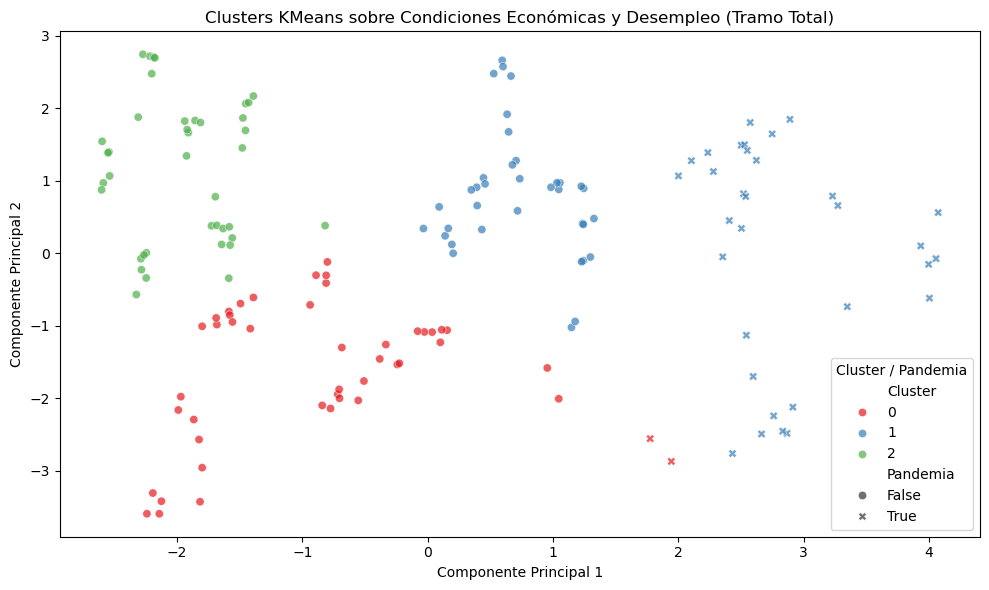

In [41]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Seleccionar variables relevantes para clustering
cluster_vars = [
    "Tasa de desempleo",
    "Sueldo nominal USD",
    "Sueldo mínimo USD",
    "Razón sueldo nominal/minimo",
    "PIB per capita",
    "Dólar observado",
    "ipc"
]

df_cluster = df_encoded[df_encoded["Tramo etario_Total"] == 1].copy()
df_cluster = df_cluster.dropna(subset=cluster_vars + ["Pandemia"])  # Eliminar filas con valores nulos

# 2. Estandarizar las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[cluster_vars])

# 3. Aplicar KMeans (e.g., 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster["Cluster"] = kmeans.fit_predict(X_scaled)

# 4. Reducir a 2 dimensiones para graficar con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_cluster["PC1"] = X_pca[:, 0]
df_cluster["PC2"] = X_pca[:, 1]

# 5. Graficar los clusters con color y estilo según Pandemia
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_cluster,
    x="PC1",
    y="PC2",
    hue="Cluster",
    style="Pandemia",
    palette="Set1",
    alpha=0.7
)
plt.title("Clusters KMeans sobre Condiciones Económicas y Desempleo (Tramo Total)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster / Pandemia")
plt.tight_layout()
plt.show()


Este bloque de código implementa un análisis de clustering con KMeans para identificar patrones similares en las condiciones económicas y la tasa de desempleo, considerando únicamente el tramo etario "Total". Primero, se seleccionan variables económicas clave como el sueldo, el PIB y el dólar observado, y se eliminan las filas con datos faltantes. Luego, estas variables se estandarizan para garantizar que todas tengan igual peso en el análisis. Se aplica el algoritmo KMeans con tres clusters, permitiendo agrupar observaciones similares. Posteriormente, se utiliza PCA para reducir la dimensionalidad del conjunto de datos a dos componentes principales, facilitando la visualización. El resultado se grafica en un plano, coloreando los puntos según su cluster asignado y diferenciando por forma si pertenecen al período pandémico. Este enfoque permite visualizar cómo se agrupan distintos contextos económicos y evaluar si la pandemia generó agrupaciones distintas.

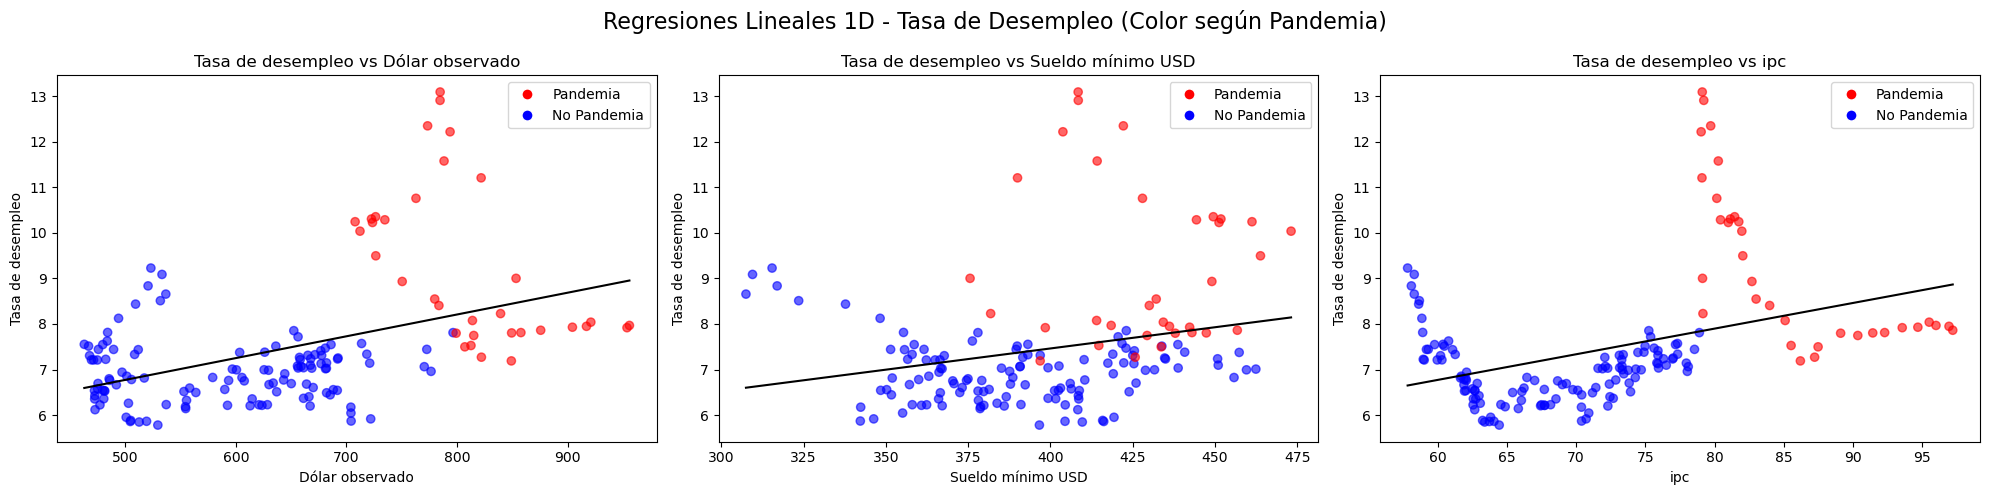

In [51]:
from sklearn.metrics import r2_score
import numpy as np

# Asegurarse que la columna Pandemia esté en formato booleano
df_total["Pandemia"] = df_total["Pandemia"].astype(bool)

# Variables dependiente e independientes
y_var = "Tasa de desempleo"
x_vars = ["Dólar observado", "Sueldo mínimo USD", "ipc",]

# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, x_var in enumerate(x_vars):
    # Eliminar filas con nulos
    df_clean = df_total[[x_var, y_var, "Pandemia"]].dropna()

    # Datos
    X = df_clean[[x_var]].values
    y = df_clean[y_var].values
    color = df_clean["Pandemia"].map({True: "red", False: "blue"}).values

    # Ajustar modelo de regresión
    model = LinearRegression()
    model.fit(X, y)
    
    # Predicción
    x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_range)
    
    # R²
    r2 = r2_score(y, model.predict(X))

    # Graficar
    ax = axes[i]
    ax.scatter(X, y, c=color, alpha=0.6, label="Datos")
    ax.plot(x_range, y_pred, color="black", label=f"Regresión (R² = {r2:.2f})")
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)
    ax.set_title(f"{y_var} vs {x_var}")
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label='Pandemia', markerfacecolor='red', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='No Pandemia', markerfacecolor='blue', markersize=8)
    ]
    ax.legend(handles=handles)

plt.suptitle("Regresiones Lineales 1D - Tasa de Desempleo (Color según Pandemia)", fontsize=16)
plt.tight_layout()
plt.show()

Este código realiza regresiones lineales simples entre la tasa de desempleo y tres variables económicas: dólar observado, sueldo mínimo en USD e IPC, utilizando datos del tramo etario "Total". Cada regresión se grafica en un subplot individual, donde los puntos se colorean según si pertenecen o no al periodo de pandemia. Se ajusta una línea de regresión para cada variable y se muestra su coeficiente de determinación 
𝑅
2
R 
2
 , que indica el nivel de ajuste del modelo.

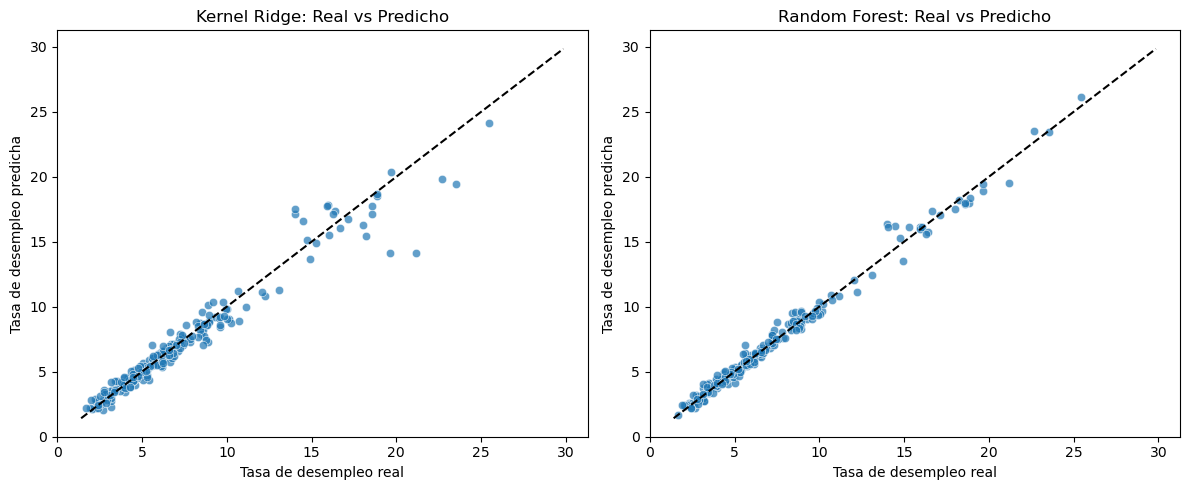

Kernel Ridge - MSE: 1.0191
Random Forest - MSE: 0.2449


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
# 1. Definir variables X e y
df_model = df_encoded.copy()
df_model = df_model.dropna(subset=["Tasa de desempleo"])  # Eliminar nulos en y

X = df_model.drop(columns=["Tasa de desempleo"])  # Todas menos la target
y = df_model["Tasa de desempleo"]

# 2. Separar en entrenamiento y test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Estandarizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Modelos
def train_kernel_ridge(X_train, y_train, alpha=1.0, kernel='rbf'):
    model = KernelRidge(alpha=alpha, kernel=kernel)
    model.fit(X_train, y_train)
    return model

def train_random_forest(X_train, y_train, n_estimators=100, max_depth=None):
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    return model

# 5. Entrenar modelos
kr_model = train_kernel_ridge(X_train_scaled, y_train)
rf_model = train_random_forest(X_train_scaled, y_train)

# 6. Predicciones
y_pred_kr = kr_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test_scaled)

# 7. Gráficos de dispersión real vs predicho
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Kernel Ridge
sns.scatterplot(x=y_test, y=y_pred_kr, ax=axes[0], alpha=0.7)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
axes[0].set_title("Kernel Ridge: Real vs Predicho")
axes[0].set_xlabel("Tasa de desempleo real")
axes[0].set_ylabel("Tasa de desempleo predicha")

# Random Forest
sns.scatterplot(x=y_test, y=y_pred_rf, ax=axes[1], alpha=0.7)
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
axes[1].set_title("Random Forest: Real vs Predicho")
axes[1].set_xlabel("Tasa de desempleo real")
axes[1].set_ylabel("Tasa de desempleo predicha")

plt.tight_layout()
plt.show()
# Calcular MSE
mse_kr = mean_squared_error(y_test, y_pred_kr)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Imprimir resultados
print(f"Kernel Ridge - MSE: {mse_kr:.4f}")
print(f"Random Forest - MSE: {mse_rf:.4f}")

Este código entrena y compara dos modelos de regresión —Kernel Ridge y Random Forest— para predecir la tasa de desempleo a partir de múltiples variables económicas y categóricas previamente codificadas. Primero se separan los datos en conjuntos de entrenamiento y prueba, estandarizando las variables para mejorar el desempeño de los modelos. Luego, ambos modelos son entrenados con los datos escalados y utilizados para predecir sobre el conjunto de prueba. Los resultados se visualizan mediante gráficos de dispersión que comparan los valores reales versus los predichos, junto con la línea de referencia ideal. El rendimiento de cada modelo se evalúa usando el error cuadrático medio (MSE), proporcionando una medida cuantitativa del ajuste. Esto permite comparar qué modelo logra una mejor precisión. Finalmente, se imprime el MSE de cada modelo para una interpretación directa.